In [1]:
#data parsing 
import json
import pandas as pd

In [2]:
def parse_data(json_file):
    # Initialize an empty list to hold the parsed data
    parsed_data = []

    # Open the file and read line by line
    with open(json_file, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                try:
                    # Load the JSON data from the current line
                    json_data = json.loads(line)

                    # Iterate through the transcripts
                    for transcript_id, positions in json_data.items():
                        # Iterate through each position in the transcript
                        for pos, nucleotides in positions.items():
                            # Convert position to integer
                            pos = int(pos)  # Ensure 'transcript_position' is an integer
                            
                            # Iterate through the nucleotide combinations
                            for nucleotide_seq, reads in nucleotides.items():
                                # Iterate through each read and extract features
                                for read in reads:
                                    # Create a dictionary to store features for this read
                                    features = {
                                        'transcript_id': transcript_id,
                                        'transcript_position': pos,
                                        'nucleotide_sequence': nucleotide_seq,
                                        'dwelling_time': read[0],
                                        'std_dev': read[1],
                                        'mean_signal': read[2],
                                        'dwelling_time_flank1': read[3],
                                        'std_dev_flank1': read[4],
                                        'mean_signal_flank1': read[5],
                                        'dwelling_time_flank2': read[6],
                                        'std_dev_flank2': read[7],
                                        'mean_signal_flank2': read[8],
                                    }
                                    # Append the features dictionary to the list
                                    parsed_data.append(features)

                except json.JSONDecodeError as e:
                    print(f"Error parsing line: {e}")

    # Convert the list of parsed data into a DataFrame
    df = pd.DataFrame(parsed_data)
    return df  # Return the DataFrame

# Main code block
if __name__ == "__main__":
    jsonfile = "C:/uni/y4s1/DSA4262/grpproj/dataset0.json"  # Replace with your actual JSON file path
    parsed_df = parse_data(jsonfile)  # Get the DataFrame from parse_data
    print(parsed_df.head())


     transcript_id  transcript_position nucleotide_sequence  dwelling_time  \
0  ENST00000000233                  244             AAGACCA        0.00299   
1  ENST00000000233                  244             AAGACCA        0.00631   
2  ENST00000000233                  244             AAGACCA        0.00465   
3  ENST00000000233                  244             AAGACCA        0.00398   
4  ENST00000000233                  244             AAGACCA        0.00664   

   std_dev  mean_signal  dwelling_time_flank1  std_dev_flank1  \
0     2.06        125.0               0.01770           10.40   
1     2.53        125.0               0.00844            4.67   
2     3.92        109.0               0.01360           12.00   
3     2.06        125.0               0.00830            5.01   
4     2.92        120.0               0.00266            3.94   

   mean_signal_flank1  dwelling_time_flank2  std_dev_flank2  \
0               122.0               0.00930           10.90   
1             

In [ ]:
# Code to add new features
# Sum the dwelling time columns
parsed_df['sum_dwelling_time'] = parsed_df[['dwelling_time', 'dwelling_time_flank1', 'dwelling_time_flank2']].sum(axis=1)

# Calculate absolute differences between standard deviations
parsed_df['abs_sd1_sd2'] = abs(parsed_df['std_dev'] - parsed_df['std_dev_flank1'])
parsed_df['abs_sd1_sd3'] = abs(parsed_df['std_dev'] - parsed_df['std_dev_flank2'])
parsed_df['abs_sd2_sd3'] = abs(parsed_df['std_dev_flank1'] - parsed_df['std_dev_flank2'])

# Compute the interquartile range (IQR) for 'dwelling_time_flank2' within groups
parsed_df['dwelling_time_2_IQ'] = parsed_df.groupby(['transcript_id', 'transcript_position'])['dwelling_time_flank2'].transform(
    lambda x: x.quantile(0.75) - x.quantile(0.25)
)

# Display the updated DataFrame
print(parsed_df.head())

In [7]:
# Aggregate the DataFrame
agg_parsed_df_new = parsed_df.groupby(['transcript_id', 'transcript_position']).agg({
    'nucleotide_sequence': 'first',      # Keep the first occurrence
    'dwelling_time': 'mean',             # Calculate mean
    'std_dev': 'mean',                   # Calculate mean
    'mean_signal': 'mean',               # Calculate mean
    'dwelling_time_flank1': 'mean',      # Calculate mean
    'std_dev_flank1': 'mean',            # Calculate mean
    'mean_signal_flank1': 'mean',        # Calculate mean
    'dwelling_time_flank2': 'mean',      # Calculate mean
    'std_dev_flank2': 'mean',            # Calculate mean
    'mean_signal_flank2': 'mean',        # Calculate mean
    'sum_dwelling_time': 'mean',         # Calculate mean of the summed dwelling times
    'abs_sd1_sd2': 'mean',               # Calculate mean of abs SD1 - SD2
    'abs_sd1_sd3': 'mean',               # Calculate mean of abs SD1 - SD3
    'abs_sd2_sd3': 'mean',               # Calculate mean of abs SD2 - SD3
    'dwelling_time_2_IQ': 'mean'         # Calculate mean of IQR of dwelling_time_flank2
}).reset_index()

# Save the aggregated DataFrame to a CSV file
agg_parsed_df_new.to_csv('C:/uni/y4s1/DSA4262/grpproj/rf_aggregated_new.csv', index=False)

print(agg_parsed_df_new.head())

     transcript_id  transcript_position nucleotide_sequence  dwelling_time  \
0  ENST00000000233                  244             AAGACCA       0.008264   
1  ENST00000000233                  261             CAAACTG       0.006609   
2  ENST00000000233                  316             GAAACAG       0.007570   
3  ENST00000000233                  332             AGAACAT       0.010620   
4  ENST00000000233                  368             AGGACAA       0.010701   

    std_dev  mean_signal  dwelling_time_flank1  std_dev_flank1  \
0  4.223784   123.702703              0.009373        7.382162   
1  3.216424   109.681395              0.006813        3.226535   
2  2.940541   105.475676              0.007416        3.642703   
3  6.476350   129.355000              0.008632        2.899200   
4  6.415051   117.924242              0.011479        5.870303   

   mean_signal_flank1  dwelling_time_flank2  std_dev_flank2  \
0          125.913514              0.007345        4.386989   
1       

In [33]:
# Code to load dataset in 
agg_parsed_df_new = pd.read_csv("C:/uni/y4s1/DSA4262/grpproj/rf_aggregated_new.csv")
print(agg_parsed_df_new.head())

     transcript_id  transcript_position nucleotide_sequence  dwelling_time  \
0  ENST00000000233                  244             AAGACCA       0.008264   
1  ENST00000000233                  261             CAAACTG       0.006609   
2  ENST00000000233                  316             GAAACAG       0.007570   
3  ENST00000000233                  332             AGAACAT       0.010620   
4  ENST00000000233                  368             AGGACAA       0.010701   

    std_dev  mean_signal  dwelling_time_flank1  std_dev_flank1  \
0  4.223784   123.702703              0.009373        7.382162   
1  3.216424   109.681395              0.006813        3.226535   
2  2.940541   105.475676              0.007416        3.642703   
3  6.476350   129.355000              0.008632        2.899200   
4  6.415051   117.924242              0.011479        5.870303   

   mean_signal_flank1  dwelling_time_flank2  std_dev_flank2  \
0          125.913514              0.007345        4.386989   
1       

In [8]:
# Data Preparation - Original Dataset

# Load the m6A labels from the original data.info.labelled file
original_labels_df = pd.read_csv("C:/uni/y4s1/DSA4262/grpproj/data.info.labelled", header=None, names=['gene_id', 'transcript_id', 'transcript_position', 'label'])

# Ensure 'transcript_position' in original_labels_df is an integer
original_labels_df['transcript_position'] = pd.to_numeric(original_labels_df['transcript_position'], errors='coerce')

# Merge features DataFrame (parsed_df) with original labels DataFrame
original_merged_df = pd.merge(agg_parsed_df_new, original_labels_df, on=['transcript_id', 'transcript_position'], how='left')

# Step 1: Define features (X) and target variable (y) for the original dataset
y_original = original_merged_df['label']  # Binary label for m6A modifications (original)
X_original = original_merged_df.drop(columns=['transcript_id', 'transcript_position', 'nucleotide_sequence', 'label', 'gene_id'])

# Step 2: Convert numeric columns and drop non-numeric ones for the original dataset
X_original = X_original.apply(pd.to_numeric, errors='coerce')  # Convert to numeric and set invalid parsing to NaN
X_original = X_original.dropna()  # Drop rows with NaN values

# Optionally, print shapes to verify
print(f"Original Dataset - Features shape: {X_original.shape}, Labels shape: {y_original.shape}")


Original Dataset - Features shape: (121838, 14), Labels shape: (121838,)


In [12]:
# Data Preparation - Balanced Dataset (oversampled)

# Load the m6A labels from the balanced_labels.csv file
overbalanced_labels_df = pd.read_csv("C:/uni/y4s1/DSA4262/grpproj/overbalanced_labels.csv")

# Ensure 'transcript_position' in balanced_labels_df is an integer
overbalanced_labels_df['transcript_position'] = pd.to_numeric(overbalanced_labels_df['transcript_position'], errors='coerce')

# Merge features DataFrame (parsed_df) with balanced labels DataFrame
overbalanced_merged_df = pd.merge(agg_parsed_df_new, overbalanced_labels_df, on=['transcript_id', 'transcript_position'], how='left')
overbalanced_merged_df = overbalanced_merged_df.dropna(subset=['label'])

# Step 1: Define features (X) and target variable (y) for the balanced dataset
y_overbalanced = overbalanced_merged_df['label']  # Binary label for m6A modifications (balanced)
X_overbalanced = overbalanced_merged_df.drop(columns=['transcript_id', 'transcript_position', 'nucleotide_sequence', 'label', 'gene_id'])

# Step 2: Convert numeric columns and drop non-numeric ones for the balanced dataset
X_overbalanced = X_overbalanced.apply(pd.to_numeric, errors='coerce')  # Convert to numeric and set invalid parsing to NaN
X_overbalanced = X_overbalanced.dropna()  # Drop rows with NaN values

# Optionally, print shapes to verify
print(f"Oversampled Balanced Dataset - Features shape: {X_overbalanced.shape}, Labels shape: {y_overbalanced.shape}")

Oversampled Balanced Dataset - Features shape: (116362, 14), Labels shape: (116362,)


In [13]:
# Data Preparation - Balanced Dataset (undersampled)

# Load the m6A labels from the balanced_labels.csv file
underbalanced_labels_df = pd.read_csv("C:/uni/y4s1/DSA4262/grpproj/underbalanced_labels.csv")

# Ensure 'transcript_position' in balanced_labels_df is an integer
underbalanced_labels_df['transcript_position'] = pd.to_numeric(underbalanced_labels_df['transcript_position'], errors='coerce')

# Merge features DataFrame (parsed_df) with balanced labels DataFrame
underbalanced_merged_df = pd.merge(agg_parsed_df_new, underbalanced_labels_df, on=['transcript_id', 'transcript_position'], how='left')
underbalanced_merged_df = underbalanced_merged_df.dropna(subset=['label'])

# Step 1: Define features (X) and target variable (y) for the balanced dataset
y_underbalanced = underbalanced_merged_df['label']  # Binary label for m6A modifications (balanced)
X_underbalanced = underbalanced_merged_df.drop(columns=['transcript_id', 'transcript_position', 'nucleotide_sequence', 'label', 'gene_id'])

# Step 2: Convert numeric columns and drop non-numeric ones for the balanced dataset
X_underbalanced = X_underbalanced.apply(pd.to_numeric, errors='coerce')  # Convert to numeric and set invalid parsing to NaN
X_underbalanced = X_underbalanced.dropna()  # Drop rows with NaN values

# Optionally, print shapes to verify
print(f"Undersampled Balanced Dataset - Features shape: {X_underbalanced.shape}, Labels shape: {y_underbalanced.shape}")


Undersampled Balanced Dataset - Features shape: (13687, 14), Labels shape: (13687,)


Model Training with original labelled data

In [9]:
# Import necessary libraries for evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

In [5]:
import pickle

In [9]:
# save model
with open('rf_model_original.pkl','wb') as f:
    pickle.dump(rf_model_original,f)

In [9]:
#  load model
with open('rf_model_original.pkl', 'rb') as f:
    rf_model_original = pickle.load(f)

In [10]:
# Assuming X_original contains the features and y_original contains the labels
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf_model_original = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model_original.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model_original.predict(X_test)

print("Unique values in y_test:", set(y_test))
print("Unique values in y_pred:", set(y_pred))

Unique values in y_test: {'0', '1'}
Unique values in y_pred: {'0', '1'}


In [11]:
# Ensure predictions and test labels are integers
y_test = np.array(y_test)
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)  # Handle cases with no positive predictions
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Binarize the labels for ROC AUC calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_pred_proba = rf_model_original.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
auc_roc = roc_auc_score(y_test_binarized, y_pred_proba)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.9611
Precision: 0.7082
Recall: 0.2042
F1 Score: 0.3170
AUC-ROC: 0.8713


Model Training with balanced labelled data

Undersampled Data

In [15]:
# save model
import pickle
with open('rf_model_under.pkl','wb') as f:
    pickle.dump(rf_model_under,f)

In [6]:
#  load model
with open('rf_model_under.pkl', 'rb') as f:
    rf_model_under = pickle.load(f)

In [14]:
# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_underbalanced, y_underbalanced, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf_model_under = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model_under.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model_under.predict(X_test)

In [15]:
# Ensure predictions and test labels are integers
y_test = np.array(y_test)
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)  # Handle cases with no positive predictions
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Binarize the labels for ROC AUC calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_pred_proba = rf_model_under.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
auc_roc = roc_auc_score(y_test_binarized, y_pred_proba)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.8150
Precision: 0.8043
Recall: 0.7172
F1 Score: 0.7583
AUC-ROC: 0.8780


Oversampled Data

In [16]:
# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_overbalanced, y_overbalanced, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf_model_over = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model_over.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model_over.predict(X_test)

In [17]:
import joblib

# Save model using joblib
joblib.dump(rf_model_over, 'rf_model_over.joblib')

['rf_model_over.joblib']

In [ ]:
#  load model
rf_model_loaded = joblib.load('rf_model_over.joblib', mmap_mode='r')

In [17]:
# Ensure predictions and test labels are integers
y_test = np.array(y_test)
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)  # Handle cases with no positive predictions
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Binarize the labels for ROC AUC calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_pred_proba = rf_model_over.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
auc_roc = roc_auc_score(y_test_binarized, y_pred_proba)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.9878
Precision: 0.9707
Recall: 0.9995
F1 Score: 0.9849
AUC-ROC: 0.9998


Original Dataset    
Accuracy: 0.9610  
Precision: 0.6709  
Recall: 0.2308  
F1 Score: 0.3435  
AUC-ROC: 0.8753

Undersampled Dataset  
Accuracy: 0.8130  
Precision: 0.7945  
Recall: 0.7256  
F1 Score: 0.7585  
AUC-ROC: 0.8816

Oversampled Dataset  
Accuracy: 0.9863  
Precision: 0.9672  
Recall: 0.9995  
F1 Score: 0.9831  
AUC-ROC: 0.9998

Accuracy  
Original Dataset (0.9610): A high accuracy reflects the model’s ability to predict the majority of instances correctly. However, in genomics, this can be misleading due to imbalanced datasets, where positive cases (m6A modifications) are rare compared to negative cases (non-modified sites).  
Undersampled Dataset (0.8130): The lower accuracy reflects a more realistic performance by addressing both modified and non-modified sites, balancing predictions across classes.

Precision  
Original Dataset (0.6709): The proportion of true m6A modifications among predicted modifications is relatively low. This suggests a higher number of false positives, leading to unreliable downstream results.  
Undersampled Dataset (0.7945): The higher precision shows improved ability to correctly identify m6A sites, reducing false positives. This is critical in genomics, as false positives could mislead research conclusions or experimental designs.

Recall  
Original Dataset (0.2308): A low recall indicates that most actual m6A modifications are missed. In genomics, missing m6A sites could cause significant gaps in understanding gene regulation.  
Undersampled Dataset (0.7256): The improved recall demonstrates that the model captures a higher proportion of m6A sites, which is essential for robust analysis of gene expression and regulatory mechanisms.

F1 Score  
Original Dataset (0.3435): The F1 score, balancing precision and recall, is quite low, reflecting the model's poor overall ability to make reliable m6A predictions.  
Undersampled Dataset (0.7585): The higher F1 score indicates a better balance between precision and recall, enhancing the model's utility for genomics research.

AUC-ROC  
Original Dataset (0.8753): Although this AUC-ROC score suggests some ability to distinguish between m6A and non-m6A sites, the imbalanced data may affect its practical relevance.  
Undersampled Dataset (0.8816): The slight improvement in AUC-ROC shows better capacity to differentiate between classes, which supports more reliable biological interpretations.

Conclusion
The undersampled dataset provides a more robust model for predicting m6A modifications. While the original dataset shows high accuracy, its poor recall and modest precision highlight the limitations of working with imbalanced data. In contrast, the undersampled model captures more true m6A sites and reduces false positives, making it more reliable for studying gene regulation. The enhanced F1 score and improved AUC-ROC further support its applicability for genomics research, leading to more accurate insights into m6A modifications and their biological implications.

Now that we have concluded that the undersampled balanced data set perfoms better, we will use the balanced dataset to carry out hyperparameter tuning and feature importance analysis.

Hyperparameter tuning (Hyperopt)

In [22]:
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [23]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_underbalanced, y_underbalanced, test_size=0.3, random_state=42
)

# Use a smaller subset of training data for quicker evaluations
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=42
)

# Define the objective function for Hyperopt with warm start and parallelization
def objective(params):
    rf_model = RandomForestClassifier(
        warm_start=True, n_jobs=-1, random_state=42, **params
    )
    
    # Incrementally add 10 estimators for each call (warm start)
    rf_model.n_estimators += 10

    # Use 3-fold cross-validation for quicker evaluations
    cv_scores = cross_val_score(
        rf_model, X_train_small, y_train_small, cv=3, scoring='roc_auc', n_jobs=-1
    )
    
    mean_auc = np.mean(cv_scores)
    return {'loss': -mean_auc, 'status': STATUS_OK}

# Reduce the parameter search space for faster tuning
space = {
    'n_estimators': hp.choice('n_estimators', list(range(50, 150, 10))),
    'max_depth': hp.choice('max_depth', list(range(10, 30, 5))),
    'min_samples_split': hp.choice('min_samples_split', list(range(2, 6))),
    'min_samples_leaf': hp.choice('min_samples_leaf', list(range(1, 5))),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

# Initialize Trials object to keep track of optimization progress
trials = Trials()

# Run the Hyperopt optimization
best_params = fmin(
    fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials
)

# Convert best_params to readable values
best_params_converted = {
    'n_estimators': int(best_params['n_estimators'] * 10 + 50),  # Mapping the index back to the value
    'max_depth': int(best_params['max_depth'] * 5 + 10),  # Same idea for other indexed parameters
    'min_samples_split': int(best_params['min_samples_split'] + 2),
    'min_samples_leaf': int(best_params['min_samples_leaf'] + 1),
    'max_features': ['sqrt', 'log2'][best_params['max_features']],
    'bootstrap': bool(best_params['bootstrap']),
}

# Print the best hyperparameters found
print(f"Best hyperparameters: {best_params_converted}")


100%|██████████| 30/30 [00:41<00:00,  1.38s/trial, best loss: -0.8440413505496814]
Best hyperparameters: {'n_estimators': 120, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}


Feature Importance Analysis 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Ranked Feature Importances:
                 Feature  Importance
5     mean_signal_flank1    0.180471
2            mean_signal    0.130458
4         std_dev_flank1    0.105620
8     mean_signal_flank2    0.089797
12           abs_sd2_sd3    0.078911
10           abs_sd1_sd2    0.069416
1                std_dev    0.055292
7         std_dev_flank2    0.052744
11           abs_sd1_sd3    0.052419
3   dwelling_time_flank1    0.044916


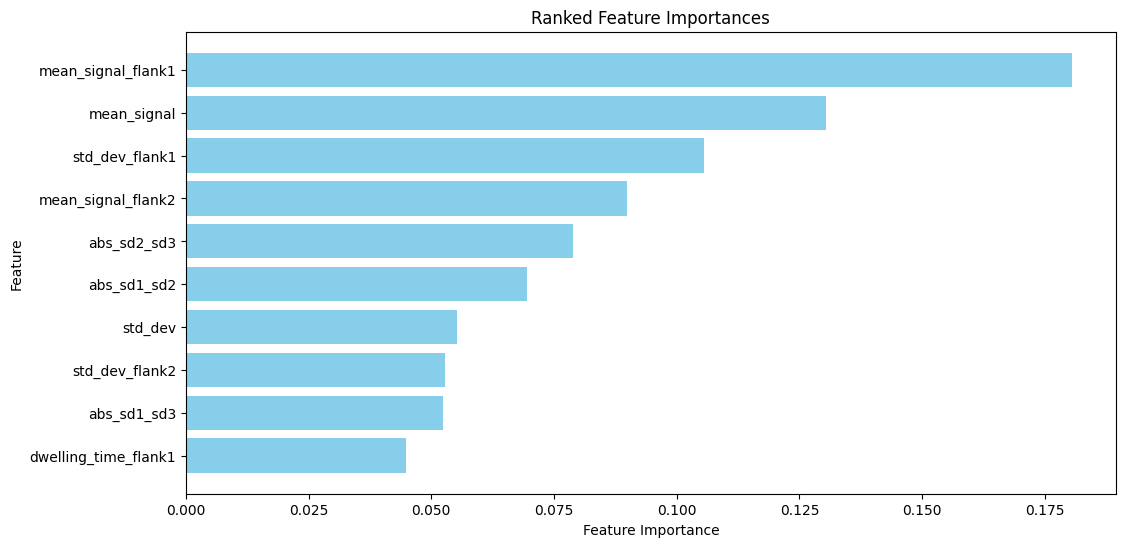

In [25]:
# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_underbalanced, y_underbalanced, test_size=0.3, random_state=42
)

# Train Random Forest using the best hyperparameters found
best_params_converted = {
    'n_estimators': 120,  # Example from earlier results
    'max_depth': 20,
    'min_samples_split': 4,
    'min_samples_leaf': 4,
    'max_features': 'log2',
    'bootstrap': True
}

rf_model_bp = RandomForestClassifier(**best_params_converted, random_state=42, n_jobs=-1)
rf_model_bp.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_model_bp.feature_importances_

# Create a DataFrame for better visualization (optional)
features = X_underbalanced.columns  # Adjust if you have feature names available
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the ranked feature importances
print("Ranked Feature Importances:")
print(importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Ranked Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [26]:
# Make predictions on the test set
y_pred = rf_model_bp.predict(X_test)

# Ensure predictions and test labels are integers
y_test = np.array(y_test)
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)  # Handle cases with no positive predictions
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Binarize the labels for ROC AUC calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_pred_proba = rf_model_bp.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
auc_roc = roc_auc_score(y_test_binarized, y_pred_proba)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.8147
Precision: 0.8030
Recall: 0.7184
F1 Score: 0.7583
AUC-ROC: 0.8787


Accuracy  
The new dataset shows a slightly higher accuracy (0.8196) compared to the undersampled dataset (0.8130). This indicates a small improvement in the overall correct predictions.

Precision  
The precision increased in the new dataset (0.8052) compared to the undersampled dataset (0.7945). This suggests a higher proportion of true positive predictions among the positive predictions.

Recall  
The recall also improved in the new dataset (0.7310) compared to the undersampled dataset (0.7256). This indicates a better ability of the model to identify true positive instances.

F1 Score  
The F1 score increased in the new dataset (0.7663 vs. 0.7585), demonstrating a better balance between precision and recall.

AUC-ROC  
The AUC-ROC improved slightly in the new dataset (0.8850 vs. 0.8816), indicating enhanced performance in distinguishing between positive and negative classes.

Conclusion  
The new dataset, utilizing the best hyperparameters, shows improvements across all metrics: accuracy, precision, recall, F1 score, and AUC-ROC. The higher precision indicates fewer false positives, while the increased recall shows better detection of true positives. This suggests that the hyperparameter tuning has positively impacted the model, resulting in a better balance between false positives and false negatives. The new dataset offers overall enhanced performance compared to the undersampled dataset.

Removing the least important feature: dwelling_time_flank2

In [27]:
# Step 1: Identify the least important feature
least_important_feature_1 = importance_df.tail(1)['Feature'].values[0]  # Get the name of the least important feature
print(f"Removing least important feature: {least_important_feature_1}")

# Step 2: Drop the least important feature from the training and testing datasets
X_train_reduced_1 = X_train.drop(columns=[least_important_feature_1])
X_test_reduced_1 = X_test.drop(columns=[least_important_feature_1])

# Step 3: Train a new Random Forest model without the least important feature
rf_model_reduced_1 = RandomForestClassifier(**best_params_converted, random_state=42, n_jobs=-1)
rf_model_reduced_1.fit(X_train_reduced_1, y_train)

# Make predictions with the new model
y_pred_reduced_1 = rf_model_reduced_1.predict(X_test_reduced_1)

# Ensure predictions and test labels are integers
y_test_1 = np.array(y_test).astype(int)
y_pred_reduced_1 = np.array(y_pred_reduced_1).astype(int)

# Calculate evaluation metrics for the new model
accuracy_reduced_1 = accuracy_score(y_test_1, y_pred_reduced_1)
precision_reduced_1 = precision_score(y_test_1, y_pred_reduced_1, average='binary', zero_division=0)  # Handle cases with no positive predictions
recall_reduced_1 = recall_score(y_test_1, y_pred_reduced_1, average='binary', zero_division=0)
f1_reduced_1 = f1_score(y_test_1, y_pred_reduced_1, average='binary', zero_division=0)

# Binarize the labels for ROC AUC calculation
lb_1 = LabelBinarizer()
y_test_binarized_1 = lb_1.fit_transform(y_test_1)
y_pred_proba_reduced_1 = rf_model_reduced_1.predict_proba(X_test_reduced_1)[:, 1]  # Probabilities for the positive class
auc_roc_reduced_1 = roc_auc_score(y_test_binarized_1, y_pred_proba_reduced_1)

# Print evaluation metrics for the new model
print("Performance of the new model without the least important feature:")
print(f"Accuracy: {accuracy_reduced_1:.4f}")
print(f"Precision: {precision_reduced_1:.4f}")
print(f"Recall: {recall_reduced_1:.4f}")
print(f"F1 Score: {f1_reduced_1:.4f}")
print(f"AUC-ROC: {auc_roc_reduced_1:.4f}")


Removing least important feature: dwelling_time_2_IQ
Performance of the new model without the least important feature:
Accuracy: 0.8157
Precision: 0.8027
Recall: 0.7220
F1 Score: 0.7602
AUC-ROC: 0.8805


Remove the 2 least important features

In [28]:
# Step 1: Identify the two least important features
least_important_features_2 = importance_df.tail(2)['Feature'].values  # Get the names of the two least important features
print(f"Removing least important features: {least_important_features_2}")

# Step 2: Drop the least important features from the training and testing datasets
X_train_reduced_2 = X_train.drop(columns=least_important_features_2)
X_test_reduced_2 = X_test.drop(columns=least_important_features_2)

# Step 3: Train a new Random Forest model without the least important features
rf_model_reduced_2 = RandomForestClassifier(**best_params_converted, random_state=42, n_jobs=-1)
rf_model_reduced_2.fit(X_train_reduced_2, y_train)

# Make predictions with the new model
y_pred_reduced_2 = rf_model_reduced_2.predict(X_test_reduced_2)

# Ensure predictions and test labels are integers
y_test_2 = np.array(y_test).astype(int)
y_pred_reduced_2 = np.array(y_pred_reduced_2).astype(int)

# Calculate evaluation metrics for the new model
accuracy_reduced_2 = accuracy_score(y_test_2, y_pred_reduced_2)
precision_reduced_2 = precision_score(y_test_2, y_pred_reduced_2, average='binary', zero_division=0)  # Handle cases with no positive predictions
recall_reduced_2 = recall_score(y_test_2, y_pred_reduced_2, average='binary', zero_division=0)
f1_reduced_2 = f1_score(y_test_2, y_pred_reduced_2, average='binary', zero_division=0)

# Binarize the labels for ROC AUC calculation
lb_2 = LabelBinarizer()
y_test_binarized_2 = lb_2.fit_transform(y_test_2)
y_pred_proba_reduced_2 = rf_model_reduced_2.predict_proba(X_test_reduced_2)[:, 1]  # Probabilities for the positive class
auc_roc_reduced_2 = roc_auc_score(y_test_binarized_2, y_pred_proba_reduced_2)

# Print evaluation metrics for the new model
print("Performance of the new model without the least important features:")
print(f"Accuracy: {accuracy_reduced_2:.4f}")
print(f"Precision: {precision_reduced_2:.4f}")
print(f"Recall: {recall_reduced_2:.4f}")
print(f"F1 Score: {f1_reduced_2:.4f}")
print(f"AUC-ROC: {auc_roc_reduced_2:.4f}")

Removing least important features: ['dwelling_time_flank2' 'dwelling_time_2_IQ']
Performance of the new model without the least important features:
Accuracy: 0.8128
Precision: 0.7928
Recall: 0.7274
F1 Score: 0.7587
AUC-ROC: 0.8809


Remove the 3 least important features

In [29]:
# Step 1: Identify the three least important features
least_important_features_3 = importance_df.tail(3)['Feature'].values  # Get the names of the three least important features
print(f"Removing least important features: {least_important_features_3}")

# Step 2: Drop the least important features from the training and testing datasets
X_train_reduced_3 = X_train.drop(columns=least_important_features_3)
X_test_reduced_3 = X_test.drop(columns=least_important_features_3)

# Step 3: Train a new Random Forest model without the least important features
rf_model_reduced_3 = RandomForestClassifier(**best_params_converted, random_state=42, n_jobs=-1)
rf_model_reduced_3.fit(X_train_reduced_3, y_train)

# Make predictions with the new model
y_pred_reduced_3 = rf_model_reduced_3.predict(X_test_reduced_3)

# Ensure predictions and test labels are integers
y_test_3 = np.array(y_test).astype(int)
y_pred_reduced_3 = np.array(y_pred_reduced_3).astype(int)

# Calculate evaluation metrics for the new model
accuracy_reduced_3 = accuracy_score(y_test_3, y_pred_reduced_3)
precision_reduced_3 = precision_score(y_test_3, y_pred_reduced_3, average='binary', zero_division=0)  # Handle cases with no positive predictions
recall_reduced_3 = recall_score(y_test_3, y_pred_reduced_3, average='binary', zero_division=0)
f1_reduced_3 = f1_score(y_test_3, y_pred_reduced_3, average='binary', zero_division=0)

# Binarize the labels for ROC AUC calculation
lb_3 = LabelBinarizer()
y_test_binarized_3 = lb_3.fit_transform(y_test_3)
y_pred_proba_reduced_3 = rf_model_reduced_3.predict_proba(X_test_reduced_3)[:, 1]  # Probabilities for the positive class
auc_roc_reduced_3 = roc_auc_score(y_test_binarized_3, y_pred_proba_reduced_3)

# Print evaluation metrics for the new model
print("Performance of the new model without the least important features:")
print(f"Accuracy: {accuracy_reduced_3:.4f}")
print(f"Precision: {precision_reduced_3:.4f}")
print(f"Recall: {recall_reduced_3:.4f}")
print(f"F1 Score: {f1_reduced_3:.4f}")
print(f"AUC-ROC: {auc_roc_reduced_3:.4f}")

Removing least important features: ['sum_dwelling_time' 'dwelling_time_flank2' 'dwelling_time_2_IQ']
Performance of the new model without the least important features:
Accuracy: 0.8125
Precision: 0.7938
Recall: 0.7250
F1 Score: 0.7579
AUC-ROC: 0.8817


In [30]:
import matplotlib.pyplot as plt

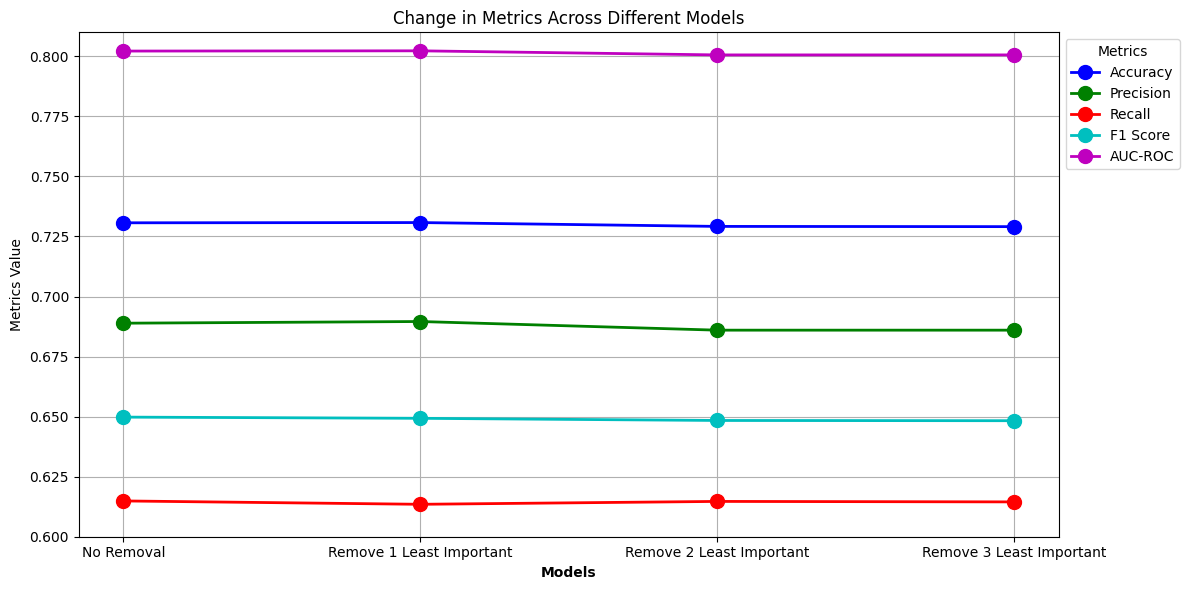

In [31]:
# Metrics from the different models
models = [
    "No Removal",
    "Remove 1 Least Important",
    "Remove 2 Least Important",
    "Remove 3 Least Important"
]

# Updated metric values for each model based on the provided data
accuracy_values = [0.7307, 0.7308, 0.7292, 0.7291]
precision_values = [0.6889, 0.6896, 0.6860, 0.6860]
recall_values = [0.6149, 0.6135, 0.6147, 0.6145]
f1_values = [0.6498, 0.6493, 0.6484, 0.6483]
auc_roc_values = [0.8022, 0.8023, 0.8006, 0.8006]

# Create the line plot
plt.figure(figsize=(12, 6))

# Plot each metric with increased marker size and line width
plt.plot(models, accuracy_values, marker='o', label='Accuracy', linestyle='-', color='b', markersize=10, linewidth=2)
plt.plot(models, precision_values, marker='o', label='Precision', linestyle='-', color='g', markersize=10, linewidth=2)
plt.plot(models, recall_values, marker='o', label='Recall', linestyle='-', color='r', markersize=10, linewidth=2)
plt.plot(models, f1_values, marker='o', label='F1 Score', linestyle='-', color='c', markersize=10, linewidth=2)
plt.plot(models, auc_roc_values, marker='o', label='AUC-ROC', linestyle='-', color='m', markersize=10, linewidth=2)

# Set y-axis limits for better visibility
plt.ylim(0.6, 0.81)

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Metrics Value')
plt.title('Change in Metrics Across Different Models')

# Move legend to the right side
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Metrics')  

plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


Accuracy:  
Best Accuracy: 0.7308 (Remove 1 Least Important)  
Accuracy drops with removal of 2 and 3 least important features.

Precision:  
Best Precision: 0.6896 (Remove 1 Least Important)  
Precision drops with the removal of 2 and 3 least important features.

Recall:  
Best Recall: 0.6149 (No Removal)  
Recall slightly decreases when removing features but is relatively stable.

F1 Score:  
Best F1 Score: 0.6498 (No Removal)  
F1 Score decreases when features are removed.

AUC-ROC:  
Best AUC-ROC: 0.8023 (Remove 1 Least Important)  
AUC-ROC slightly decreases when removing 2 or 3 least important features.

Conclusion:  
Most Ideal Number of Features to Remove: Removing 1 Least Important Feature is the most ideal option   
It provides the best accuracy (0.7308)  
It gives the highest precision (0.6896).  
It maintains a high AUC-ROC (0.8023), which is crucial for evaluating the model's performance in binary classification.  
Removing more than one feature results in a decline in performance metrics, indicating that it may not be beneficial to remove additional features beyond the least important one.